# Problem Statement 

### Context 
When deciding what courses to take, the typical Harvard student looks first to the Q-Guide, a compilation of the wisdom of Harvard students not too yonder. It contains both descriptive facts about classes — such as class enrollment size, favorability rating of professors, and average weekly workload — as well as normative judgments by students in the form of open-response comments on the course. 

### Course of Action 
Through exploratory data analysis and model generation, we aim understand how these comments and ratings affect students' decisions to enroll in classes.

We also plan to investigate other questions of interest such as: How do departments differ in terms of average course sentiment? Do smaller concentrations lessen undesirable factors to boost enrollment? How do comments and grading styles differ between required vs elective courses?

### Goal 
 Our goal is to predict course enrollment in a course in the next year based on the three previous years Q-guide ratings. While doing so we will look at feature importance to identify the most significant predictors for a student to enroll in the course. 


# Step 0: Importing Libraries 

In [1]:
# Import libraries
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler, OneHotEncoder, PolynomialFeatures
from sklearn.metrics import r2_score
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import Ridge, Lasso, LinearRegression
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import cross_val_score
from itertools import groupby
from operator import itemgetter
from utils import course_department_map, spec_course_department_map


# pandas tricks for better display
pd.options.display.max_columns = 50  
pd.options.display.max_rows = 500     
pd.options.display.max_colwidth = 100
pd.options.display.precision = 3

# Step 1: Data Reading

In [2]:
# Load the datasets
df = pd.read_csv("data/data.csv", index_col = 0)
df.head()

C:\Users\AndrewsMatthewHaines\AppData\Local\Temp\ipykernel_1556\2013055878.py:2: DtypeWarning: Columns (56,58) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("data/data.csv", index_col = 0)


,web-scraper-order,web-scraper-start-url,course,comments,year,term,course_title,course_number1,department1,course_number2,department2,name_key1,instructor_first_name,instructor_last_name,enrollment,responses,number_of_comments,Course_Overall_Rating,Course_Materials_Rating,Course_Assignments_Rating,Course_Feedback_Rating,Course_Section_Rating,Course_Workload_Rating,Course_Goals_Rating,Course_Recommend_Rating,...,Course_Recommend_Respondents,Course_Money_Respondents,Instructor_Return_Respondents,Instructor_Feedback_Respondents,Instructor_Participation_Respondents,Instructor_Enthusiasm_Respondents,Instructor_Accessible_Respondents,Instructor_Lectures_Respondents,Instructor_Overall_Respondents,Course_Overall_Distribution,Course_Materials_Distribution,Course_Assignments_Distribution,Course_Feedback_Distribution,Course_Section_Distribution,Course_Workload_Distribution,Course_Goals_Distribution,Course_Recommend_Distribution,Course_Money_Distribution,Instructor_Return_Distribution,Instructor_Feedback_Distribution,Instructor_Participation_Distribution,Instructor_Enthusiasm_Distribution,Instructor_Accessible_Distribution,Instructor_Lectures_Distribution,Instructor_Overall_Distribution
0,1522891683-18234,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 112: Black Humor: Performance Art and Literature,[],2006,fall,Black Humor: Performance Art and Literature,112,AFRAMER,NaN,NaN,AFRAMER 112,"""","""",45,21,0,4.1,4.4,3.8,3.6,4.0,3.0,NaN,4.2,...,21.0,NaN,7.0,9.0,19.0,20.0,20.0,20.0,20.0,"[1, 3, 0, 6, 11]","[0, 1, 2, 5, 13]","[1, 3, 1, 9, 6]","[2, 4, 2, 5, 8]","[1, 1, 3, 8, 7]","[9, 11, 1, 0, 0]",NaN,"[3, 1, 0, 2, 15]",NaN,"[0, 1, 2, 2, 15]","[0, 1, 2, 7, 10]","[0, 0, 1, 3, 16]","[0, 0, 3, 1, 16]","[0, 0, 2, 3, 14]","[1, 0, 1, 4, 3]","[0, 0, 1, 3, 3]"
1,1522891674-18223,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 113: Fictions of Race, Facts of Racism: Perspectives from South African and African Ame...",[],2006,fall,"Fictions of Race, Facts of Racism: Perspectives from South African and African American Drama an...",113,AFRAMER,NaN,NaN,AFRAMER 113,NaN,NaN,0,[],0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,1522891670-18217,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 116: Autobiography and Literary Imagination,[],2006,fall,Autobiography and Literary Imagination,116,AFRAMER,NaN,NaN,AFRAMER 116,"""","""",9,5,0,4.5,4.2,3.8,3.2,3.8,10.0,NaN,4.8,...,4.0,NaN,3.0,3.0,4.0,4.0,4.0,4.0,4.0,"[0, 0, 0, 2, 2]","[0, 0, 0, 3, 1]","[0, 1, 1, 0, 2]","[1, 1, 0, 0, 2]","[1, 0, 0, 1, 2]","[0, 0, 2, 2, 0]",NaN,"[0, 0, 0, 1, 3]",NaN,"[0, 0, 0, 2, 2]","[0, 1, 0, 1, 2]","[0, 0, 1, 2, 1]","[0, 0, 0, 1, 3]","[0, 1, 0, 0, 3]","[0, 1, 0, 0, 2]","[0, 1, 0, 0, 2]"
3,1522891657-18200,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,AFRAMER 175: Introduction to African Music,[],2006,fall,Introduction to African Music,175,AFRAMER,NaN,NaN,AFRAMER 175,"""","""",14,13,0,4.4,4.1,3.7,4.0,4.0,5.0,NaN,4.7,...,13.0,NaN,10.0,12.0,10.0,13.0,9.0,12.0,13.0,"[0, 1, 2, 1, 9]","[0, 1, 1, 7, 4]","[0, 1, 4, 6, 2]","[0, 1, 3, 4, 5]","[0, 0, 0, 1, 0]","[2, 7, 4, 0, 0]",NaN,"[0, 0, 0, 4, 9]",NaN,"[0, 0, 1, 3, 9]","[0, 0, 2, 3, 7]","[0, 1, 5, 1, 2]","[0, 0, 1, 4, 8]","[0, 1, 0, 3, 6]","[0, 2, 2, 6, 2]","[0, 1, 3, 4, 2]"
4,1522891495-18013,https://course-evaluation-reports.fas.harvard.edu/fas/list?yearterm=2006_1,"AFRAMER 190: African-American Families: Politics, Culture, Experience",[],2006,fall,"African-American Families: Politics, Culture, Experience",190,AFRAMER,NaN,NaN,AFRAMER 190,"""","""",13,8,0,4.4,4.4,4.1,4.1,0.0,3.0,NaN,4.4,...,7.0,NaN,6.0,6.0,7.0,7.0,6.0,7.0,7.0,"[0, 0, 1, 2, 4]","[0, 0, 0, 4, 3]","[0, 1, 0, 3, 3]","[0, 1, 0, 3, 3]",[],"[2, 5, 0, 0, 0]",NaN,"[0, 0, 1, 2, 4]",NaN,"[0, 0, 1, 2, 4]","[0, 0, 1, 4, 2]","[0, 1, 1, 0, 4]","[0, 0, 1, 3, 3]","[0, 0, 1,

# Step 2 Creating New Course Categories 
The following code is used to create both general and specific course categories to make more meaningful insights into the data. 

For general categories, courses are divided into 'Arts & Humanities', 'STEM', 'Social Sciences', 'Expository', 'General Education', and 'First-Year' departments. For specific categories, these general ones are broken down further into more specific sub-types. 

### Create general and specific class categories and do some cleaning

In [3]:
df_copy = df.copy()

# Make responses numeric, and calculate response rate
df_copy["responses"] = pd.to_numeric(df_copy["responses"], errors='coerce', downcast='integer')
df_copy['response_rate'] = df_copy['responses'] / df_copy['enrollment']

# Ensure the year is consistent change from academic year to calendar year
df_copy['school_year'] = df_copy.apply(lambda row: str(row['year']) if row['term'] == 'Spring' else str(row['year'] - 1), axis=1)

# Add division and spec_division columns from utils.py
df_copy['division'] = np.vectorize(course_department_map.get)(df_copy['department1'])
df_copy['spec_division'] = np.vectorize(spec_course_department_map.get)(df_copy['department1'])

# View the changed/new columns
df_copy[["responses","school_year", "response_rate","division", "spec_division"]].head()

,responses,school_year,response_rate,division,spec_division
0,21.0,2005,0.467,social_science,ethnic_studies
1,NaN,2005,NaN,social_science,ethnic_studies
2,5.0,2005,0.556,social_science,ethnic_studies
3,13.0,2005,0.929,social_science,ethnic_studies
4,8.0,2005,0.615,social_science,ethnic_studies


### Lecture or Seminar

We decided that we define a lecture as > 20 people because from our experience 20 people is the maximum number of people you can have in a seminar with faciliated discussion and when we plot it below it seems at though 20 people is a natural dropoff point.

<Axes: xlabel='enrollment', ylabel='Count'>

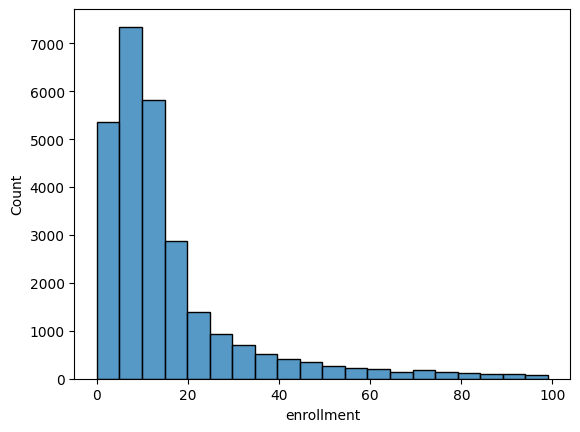

In [4]:
sns.histplot(data=df_copy[df_copy["enrollment"] < 100], x="enrollment", bins=20)

In [5]:
threshold = 20  
df_copy['course_type'] = df_copy['enrollment'].apply(lambda x: 'seminar' if x <= threshold else 'lecture')

# Step 3: Identifiying and Cleaning Missing Data 
Look at the missing data and drop columns with more than 50% of the data missing. Includes summary statistics, and data shapes.

### Generating Missingness Percentage for Each Column

In [6]:
# Calculate the percentage of missing values for each column
missing_percentage = df_copy.isnull().mean() * 100

# Display the percentage of missing data by column
missing_percentage.sort_values(ascending=False)

Course_Goals_Respondents                 99.996
Course_Goals_Distribution                99.996
Course_Goals_Rating                      99.996
course_number2                           99.060
department2                              99.060
Course_Money_Distribution                91.721
Course_Money_Rating                      91.718
Course_Money_Respondents                 91.718
Instructor_Return_Distribution           34.960
Instructor_Return_Respondents            34.960
Instructor_Return_Rating                 34.960
Instructor_Enthusiasm_Respondents        33.097
Instructor_Enthusiasm_Distribution       33.097
Instructor_Enthusiasm_Rating             33.097
Instructor_Overall_Distribution          29.632
Instructor_Overall_Rating                29.632
Instructor_Overall_Respondents           29.632
Instructor_Participation_Respondents     29.622
Instructor_Lectures_Rating               29.622
Instructor_Accessible_Rating             29.622
Instructor_Accessible_Respondents       

### Removing Columns with more than 50% Missingness

Note we impute values below after our EDA

In [7]:
# Remove columns with more than 50% missing values
columns_to_drop = missing_percentage[missing_percentage > 50].index
data_cleaned = df_copy.drop(columns=columns_to_drop)
data_cleaned = data_cleaned.drop(columns = ['web-scraper-order','web-scraper-start-url'])

# Show the shape of the data before and after
original_shape = df.shape
cleaned_shape = data_cleaned.shape

original_shape, cleaned_shape, columns_to_drop.tolist()

((28398, 65),
 (28398, 60),
 ['course_number2',
  'department2',
  'Course_Goals_Rating',
  'Course_Money_Rating',
  'Course_Goals_Respondents',
  'Course_Money_Respondents',
  'Course_Goals_Distribution',
  'Course_Money_Distribution'])

In [8]:
data_cleaned.describe()

,year,enrollment,responses,number_of_comments,Course_Overall_Rating,Course_Materials_Rating,Course_Assignments_Rating,Course_Feedback_Rating,Course_Section_Rating,Course_Workload_Rating,Course_Recommend_Rating,Instructor_Return_Rating,Instructor_Feedback_Rating,Instructor_Participation_Rating,Instructor_Enthusiasm_Rating,Instructor_Accessible_Rating,Instructor_Lectures_Rating,Instructor_Overall_Rating,Course_Overall_Respondents,Course_Materials_Respondents,Course_Assignments_Respondents,Course_Feedback_Respondents,Course_Section_Respondents,Course_Workload_Respondents,Course_Recommend_Respondents,Instructor_Return_Respondents,Instructor_Feedback_Respondents,Instructor_Participation_Respondents,Instructor_Enthusiasm_Respondents,Instructor_Accessible_Respondents,Instructor_Lectures_Respondents,Instructor_Overall_Respondents,response_rate
count,28398.000,28398.000,25209.000,28398.000,25001.000,25001.000,25001.000,25001.000,25000.000,24896.000,25001.000,18470.000,19991.000,19986.000,18999.000,19986.000,19986.000,19983.000,25001.000,25001.000,25001.000,25001.000,25000.000,25001.000,25001.000,18470.000,19991.000,19986.000,18999.000,19986.000,19986.000,19983.000,25209.000
mean,2012.243,22.517,20.311,11.861,4.225,4.175,4.077,4.081,3.618,5.977,4.262,4.324,4.011,4.218,4.409,4.259,4.222,4.373,20.088,19.458,19.605,19.227,15.043,19.254,19.967,8.152,7.741,12.607,18.500,15.952,18.113,18.737,0.784
std,3.416,48.031,42.742,46.760,0.579,0.748,0.754,0.805,1.678,3.873,0.576,0.699,1.171,0.931,0.740,0.802,0.936,0.563,42.292,41.786,42.120,41.471,39.593,41.186,42.107,10.331,9.545,19.857,36.224,29.532,36.252,36.375,0.196
min,2006.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,1.000,0.000,0.000,0.000,0.000,0.000,0.000,0.028
25%,2009.000,6.000,5.000,0.000,3.900,3.900,3.800,3.700,3.400,4.000,4.000,4.000,3.800,4.000,4.200,4.000,4.000,4.000,5.000,5.000,5.000,5.000,1.000,5.000,5.000,3.000,3.000,4.000,5.000,5.000,4.000,5.000,0.667
50%,2012.000,11.000,9.000,0.000,4.300,4.300,4.200,4.200,4.200,5.400,4.300,4.500,4.300,4.400,4.600,4.400,4.500,4.500,9.000,9.000,9.000,9.000,3.000,9.000,9.000,6.000,6.000,7.000,9.000,8.000,8.000,9.000,0.833
75%,2015.000,19.000,17.000,8.000,4.700,4.600,4.500,4.600,4.800,7.200,4.700,4.900,4.800,4.800,4.900,4.800,4.800,4.800,17.000,16.000,16.000,16.000,11.000,16.000,17.000,10.000,10.000,13.000,16.000,15.000,16.000,16.000,0.929
max,2018.000,921.000,856.000,2246.000,5.000,5.000,5.000,5.000,5.000,96.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,5.000,849.000,848.000,848.000,848.000,733.000,851.000,847.000,202.000,191.000,597.000,707.000,594.000,712.000,713.000,2.750


# Step 4: Exploratory Data Analysis
Analyzing data and generating visualizations by focusing on trends across general departments. By doing so, this will inform our model pipeline later on. 

In [9]:
average_enrollment = data_cleaned.groupby('division')['enrollment'].mean().reset_index()
average_enrollment

,division,enrollment
0,arts_humanities,15.048
1,expository,26.489
2,first_year,9.311
3,general_education,72.102
4,misc,5.333
5,social_science,24.021
6,stem,29.155


### Visualizing Average Enrollment 

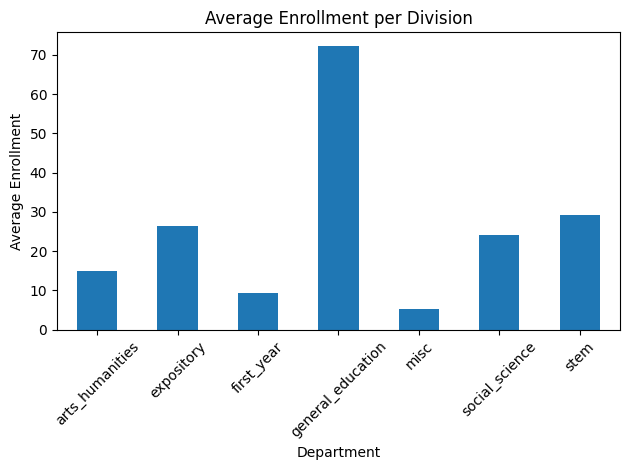

In [10]:
# Plot the average enrollment per department as a bar chart
average_enrollment.plot(kind='bar', x='division', y='enrollment', legend=False)

# Set the title and labels
plt.title('Average Enrollment per Division')
plt.xlabel('Department')
plt.ylabel('Average Enrollment')
plt.xticks(rotation=45)  # Rotate the x-axis labels to show them better

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

### Visualizing Total Enrollment 

Text(0, 0.5, 'Total Enrollment')

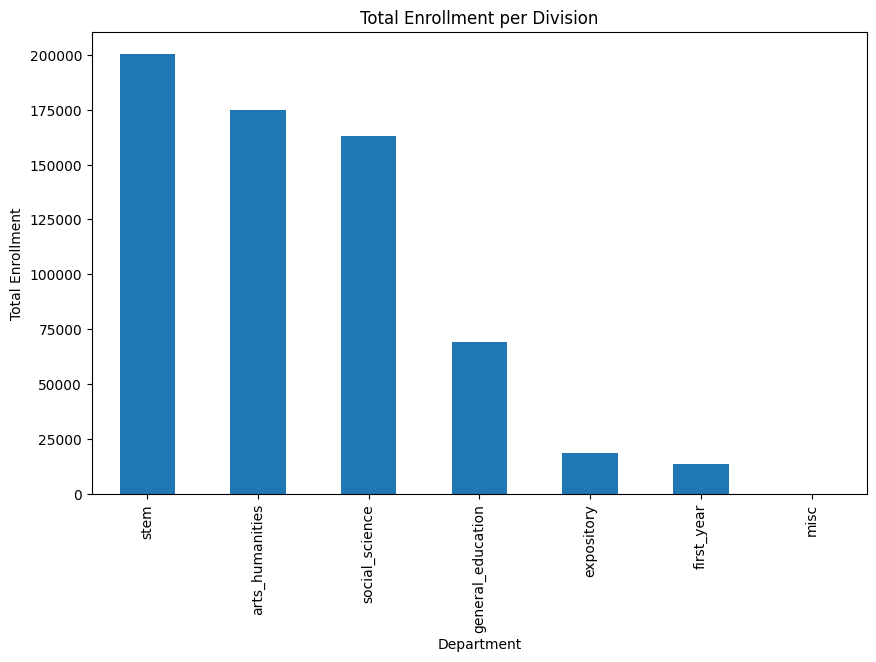

In [11]:
total_enrollment = data_cleaned.groupby('division')['enrollment'].sum().sort_values(ascending=False)

# Plotting the total enrollment per department as a bar chart
total_enrollment.plot(kind='bar', figsize=(10, 6))

# Adding title and labels
plt.title('Total Enrollment per Division')
plt.xlabel('Department')
plt.ylabel('Total Enrollment')

### Visualizing Total Enrollment over Time

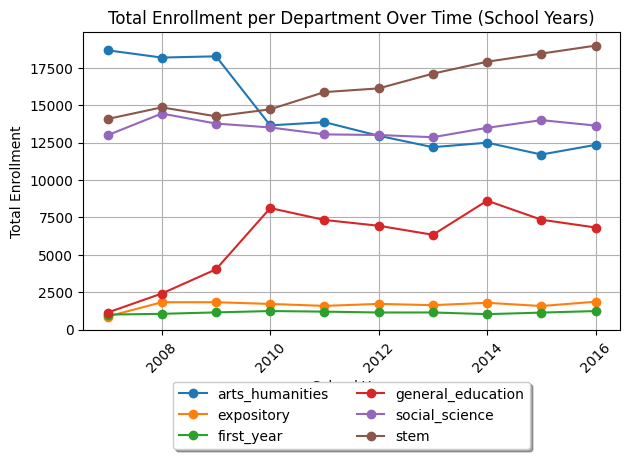

In [12]:
# Filter out 'misc' department and the years 2005 and 2017
filtered_df = data_cleaned[(data_cleaned['division'] != 'misc') & (data_cleaned['year'] > 2006) & (data_cleaned['year'] < 2017)]

# Group by department and school_year and sum enrollment
grouped_df_filtered = filtered_df.groupby(['division', 'year']).agg({'enrollment': 'sum'}).reset_index()

# Pivot the DataFrame for easier plotting
pivot_df_filtered = grouped_df_filtered.pivot(index='year', columns='division', values='enrollment')

# Plotting
pivot_df_filtered.plot(kind='line', marker='o')
plt.title('Total Enrollment per Department Over Time (School Years)')
plt.xlabel('School Year')
plt.ylabel('Total Enrollment')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.tight_layout()
plt.show()

In [13]:
data_cleaned.loc[(data_cleaned['enrollment'] > 20) & 
            (data_cleaned['division'] == 'expository') & 
            (data_cleaned['year'].isin([2005,2006,2007,2008,2009,2010,2011,2012,2013,2014,2015,2016,2017,2018,2019,2020])), 'enrollment'] = 20

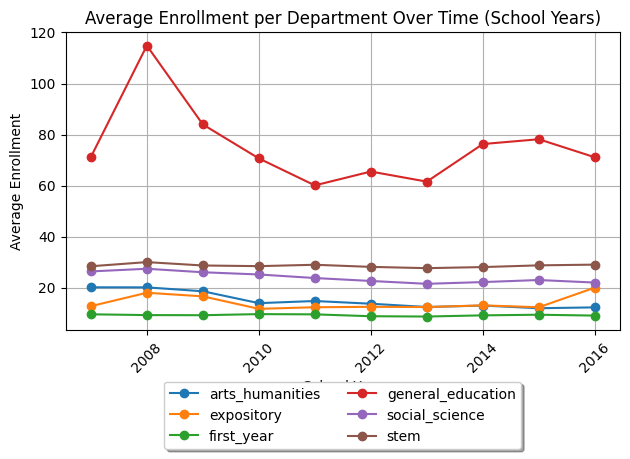

In [14]:
# Filter out 'misc' department and the years 2005 and 2017
filtered_df = data_cleaned[(data_cleaned['division'] != 'misc') & (data_cleaned['year'] > 2006) & (data_cleaned['year'] < 2017)]

# Group by department and school_year and sum enrollment
grouped_df_filtered = filtered_df.groupby(['division', 'year']).agg({'enrollment': 'mean'}).reset_index()

# Pivot the DataFrame for easier plotting
pivot_df_filtered = grouped_df_filtered.pivot(index='year', columns='division', values='enrollment')

# Plotting
pivot_df_filtered.plot(kind='line', marker='o')
plt.title('Average Enrollment per Department Over Time (School Years)')
plt.xlabel('School Year')
plt.ylabel('Average Enrollment')
plt.xticks(rotation=45)
plt.grid(True)
plt.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), shadow=True, ncol=2)
plt.tight_layout()
plt.show()

### Visualizing Average Response Rate 

In [15]:
# For the sake of visualization - drop all classes with enrollment below 5 (outliers)
# Note we do not drop this in our modelling
df_copy_drop5 = data_cleaned[(data_cleaned['enrollment'] > 5) & (data_cleaned['division'] != 'misc')]

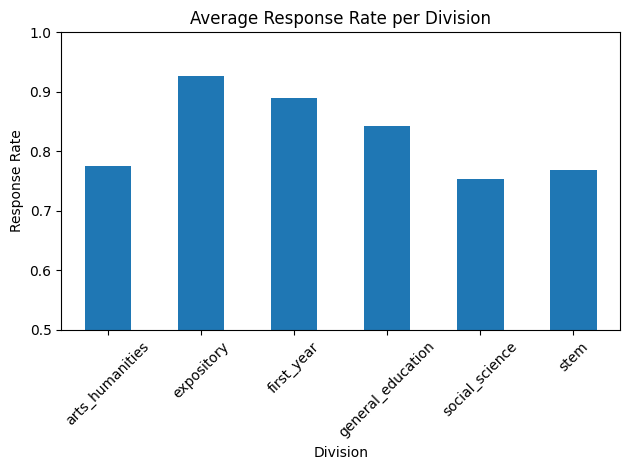

In [16]:
average_rr = df_copy_drop5.groupby('division')['response_rate'].mean().reset_index()

# Plot the average enrollment per department as a bar chart
average_rr.plot(kind='bar', x='division', y='response_rate', legend=False)

# Set the title and labels
plt.title('Average Response Rate per Division')
plt.xlabel('Division')
plt.ylabel('Response Rate')
plt.ylim(0.5, 1)
plt.xticks(rotation=45)  # Rotate the x-axis labels to show them better

# Show the plot
plt.tight_layout()  # Adjust the plot to ensure everything fits without overlapping
plt.show()

### Visualizing Average Course Rating Variables 

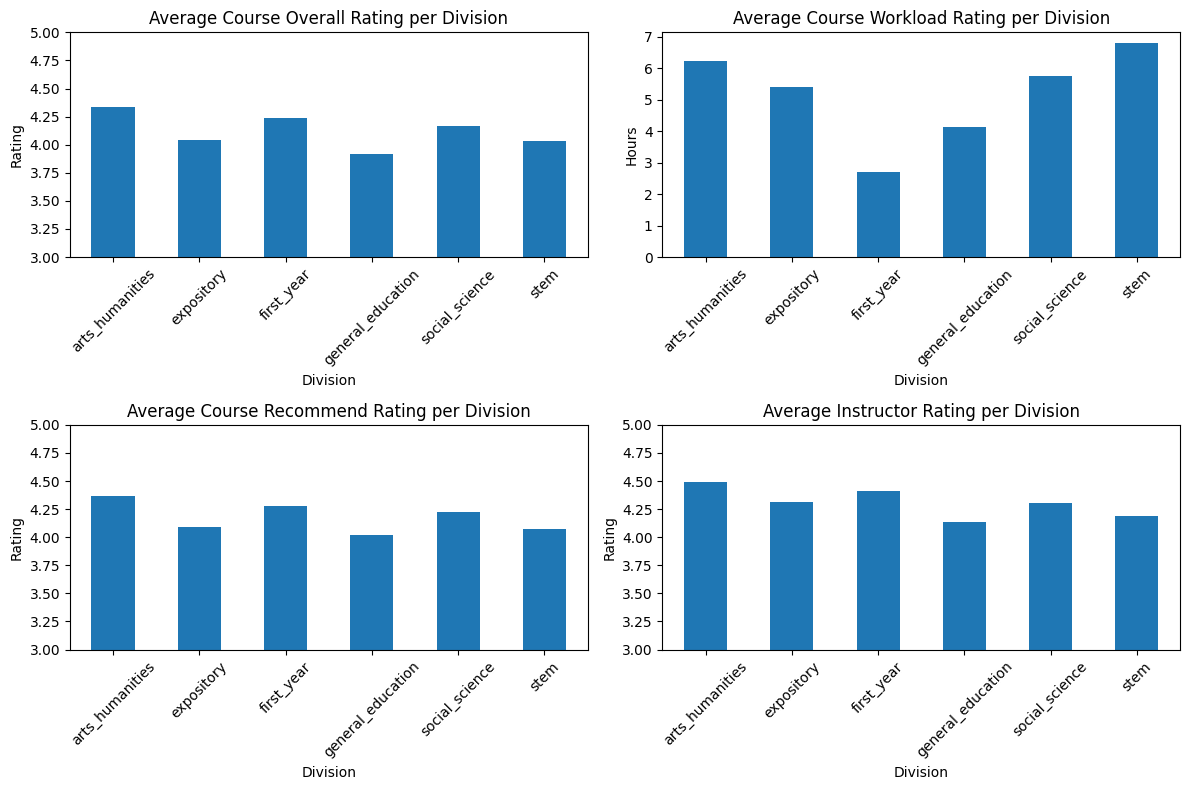

In [17]:
# Create a 2x2 grid of subplots
fig, axs = plt.subplots(2, 2, figsize=(12, 8))

# First plot
average_cor = df_copy_drop5.groupby('division')['Course_Overall_Rating'].mean().reset_index()
average_cor.plot(kind='bar', x='division', y='Course_Overall_Rating', legend=False, ax=axs[0, 0])
axs[0, 0].set_title('Average Course Overall Rating per Division')
axs[0, 0].set_xlabel('Division')
axs[0, 0].set_ylabel('Rating')
axs[0, 0].set_ylim(3, 5)
axs[0, 0].tick_params(axis='x', rotation=45)

# Second plot
average_cwr = df_copy_drop5.groupby('division')['Course_Workload_Rating'].mean().reset_index()
average_cwr.plot(kind='bar', x='division', y='Course_Workload_Rating', legend=False, ax=axs[0, 1])
axs[0, 1].set_title('Average Course Workload Rating per Division')
axs[0, 1].set_xlabel('Division')
axs[0, 1].set_ylabel('Hours')
axs[0, 1].tick_params(axis='x', rotation=45)

# Third plot
average_crr = df_copy_drop5.groupby('division')['Course_Recommend_Rating'].mean().reset_index()
average_crr.plot(kind='bar', x='division', y='Course_Recommend_Rating', legend=False, ax=axs[1, 0])
axs[1, 0].set_title('Average Course Recommend Rating per Division')
axs[1, 0].set_xlabel('Division')
axs[1, 0].set_ylabel('Rating')
axs[1, 0].set_ylim(3, 5)
axs[1, 0].tick_params(axis='x', rotation=45)

# Fourth plot
average_ior = df_copy_drop5.groupby('division')['Instructor_Overall_Rating'].mean().reset_index()
average_ior.plot(kind='bar', x='division', y='Instructor_Overall_Rating', legend=False, ax=axs[1, 1])
axs[1, 1].set_title('Average Instructor Rating per Division')
axs[1, 1].set_xlabel('Division')
axs[1, 1].set_ylabel('Rating')
axs[1, 1].set_ylim(3, 5)
axs[1, 1].tick_params(axis='x', rotation=45)

# Adjust layout and show plot
plt.tight_layout()
plt.show()

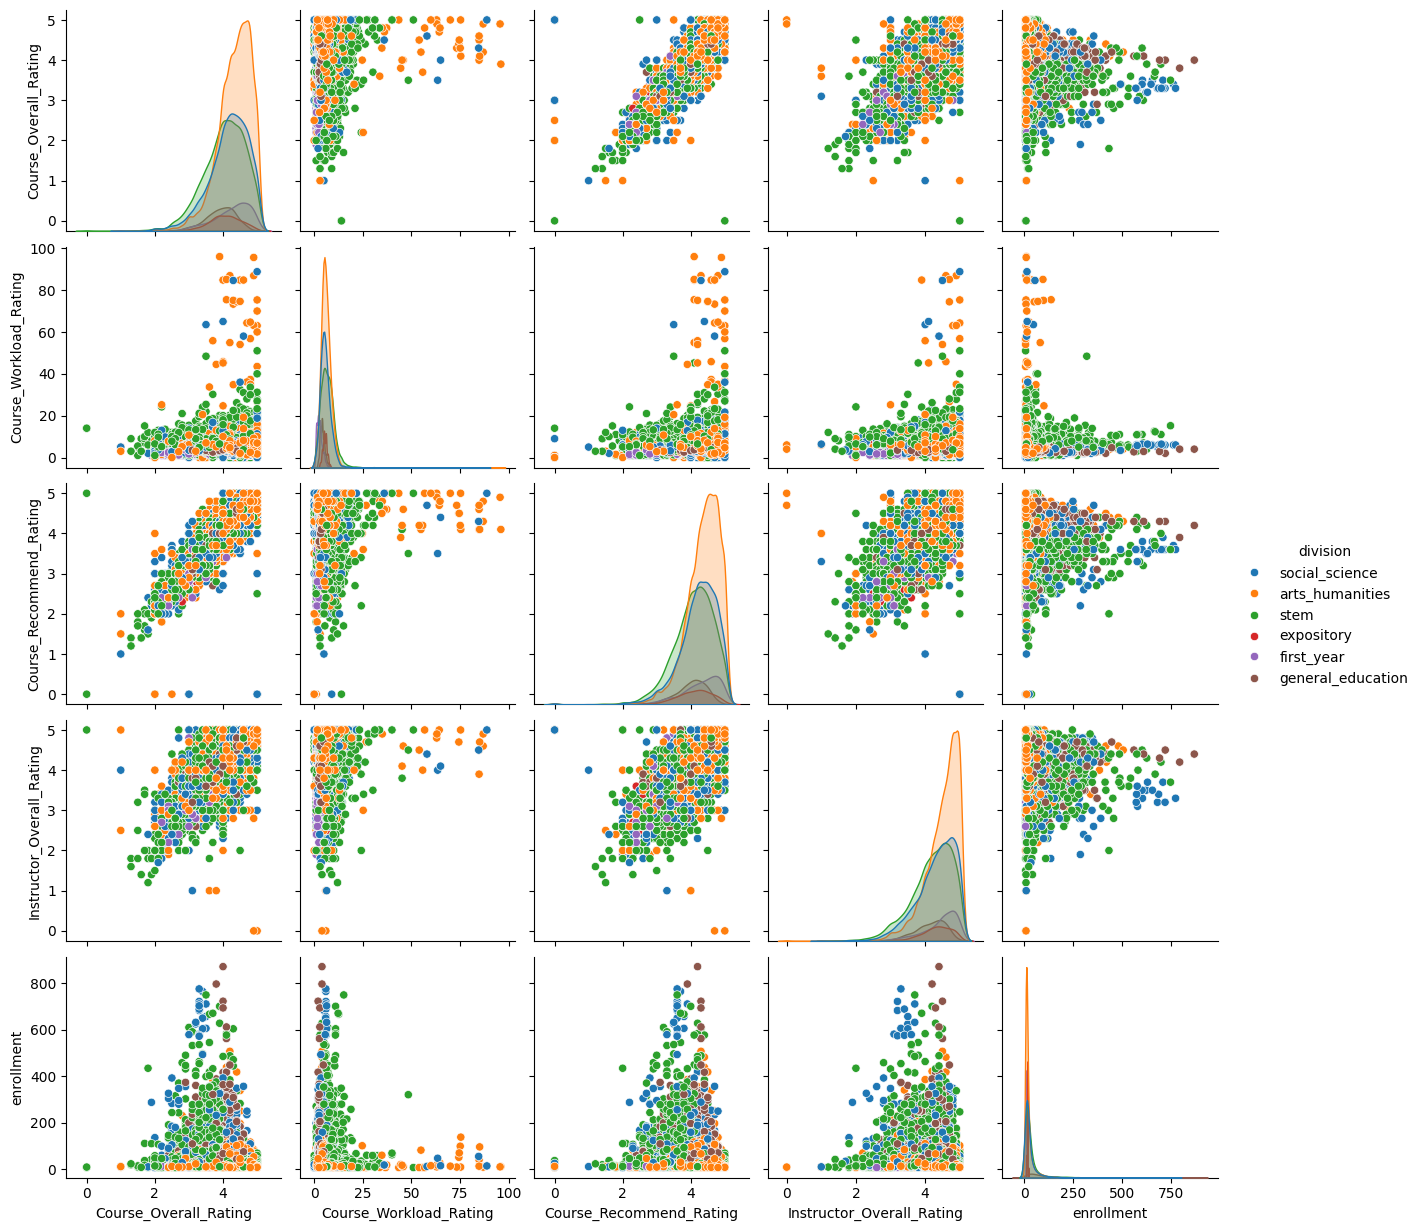

In [18]:
df_copy_drop5 = df_copy_drop5.reset_index(drop=True)

# Select only the columns you're interested in
columns = ['Course_Overall_Rating', 'Course_Workload_Rating', 'Course_Recommend_Rating', 'Instructor_Overall_Rating', 'enrollment', 'division']

# Create a pairplot using Seaborn
sns.pairplot(df_copy_drop5[columns], hue = "division")

# Show the plot
plt.show()

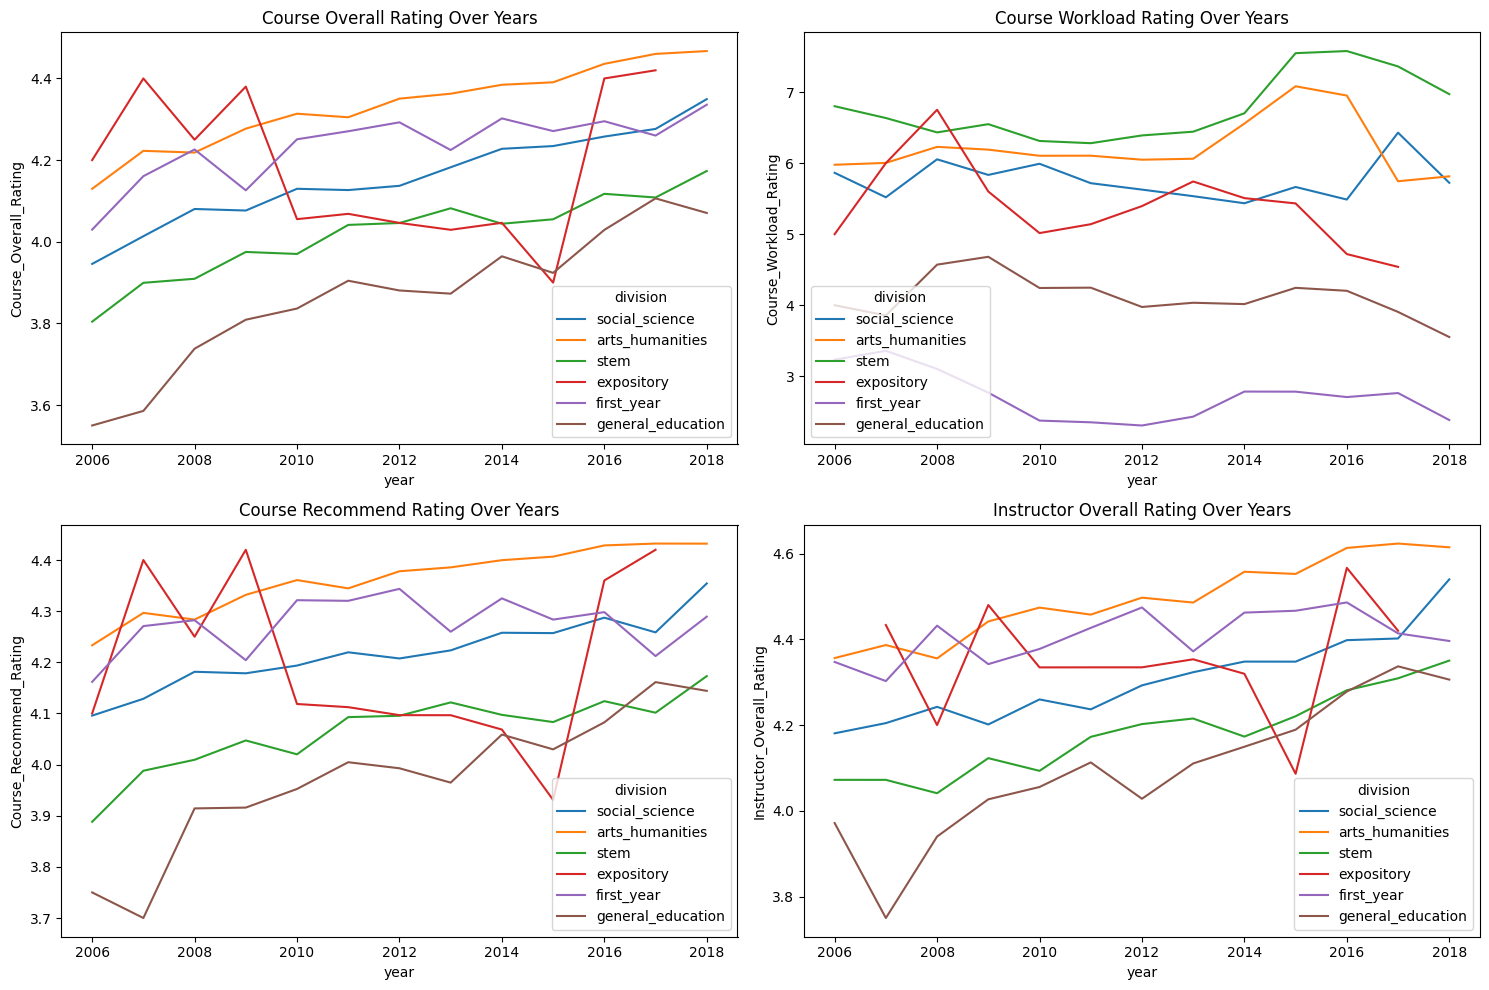

In [19]:
fig, axs = plt.subplots(2, 2, figsize=(15, 10))

# Assuming the year column is named 'year'
# Replace 'df' with the name of your DataFrame

# Plot 1: Course_Overall_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Course_Overall_Rating', hue='division', ax=axs[0, 0], errorbar = None)
axs[0, 0].set_title('Course Overall Rating Over Years')

# Plot 2: Course_Workload_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Course_Workload_Rating', hue='division', ax=axs[0, 1], errorbar = None)
axs[0, 1].set_title('Course Workload Rating Over Years')

# Plot 3: Course_Recommend_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Course_Recommend_Rating', hue='division', ax=axs[1, 0], errorbar = None)
axs[1, 0].set_title('Course Recommend Rating Over Years')

# Plot 4: Instructor_Overall_Rating over years
sns.lineplot(data=df_copy_drop5, x='year', y='Instructor_Overall_Rating', hue='division', ax=axs[1, 1], errorbar = None)
axs[1, 1].set_title('Instructor Overall Rating Over Years')

# Adjust the layout
plt.tight_layout()

# Show the plots
plt.show()

# Step 5: Scale

In [20]:
# log enrollment numbers (to not have inf replace 0 with 1e-9)
data_cleaned['enrollment'] = data_cleaned['enrollment'].replace(0, 1e-9)
data_cleaned['log_enrollment'] = np.log(data_cleaned['enrollment'])

# normalize workload hours
std_scaler = StandardScaler()
data_cleaned['norm_Course_Workload_Rating'] = std_scaler.fit_transform(data_cleaned[['Course_Workload_Rating']])

In [21]:
# Remove infinite values
data_cleaned.replace([np.inf, -np.inf], np.nan, inplace=True)

# Step 6: Begin Imputing

In [22]:
# Identify the data types of the remaining columns
column_data_types = data_cleaned.dtypes

# Separate columns by data type for potential different imputation methods
categorical_columns = column_data_types[column_data_types == 'object'].index.tolist()
numerical_columns = column_data_types[column_data_types != 'object'].index.tolist()

In [23]:
# Impute missing values for numerical columns with median
num_imputer = SimpleImputer(strategy='median')  
data_cleaned[numerical_columns] = num_imputer.fit_transform(data_cleaned[numerical_columns])

# Impute missing values for categorical columns with mode
cat_imputer = SimpleImputer(strategy='most_frequent')
data_cleaned[categorical_columns] = cat_imputer.fit_transform(data_cleaned[categorical_columns])

# Step 7: Train-test split

In [24]:
data_processed = data_cleaned.copy()

In [25]:
training_threshold = 3

# Getting unique courses
unique_courses = data_processed['name_key1'].unique()

# Filtering the dataset to keep only those courses that have at least 3 instances
data_filtered = data_processed.groupby('name_key1').filter(lambda x: len(x) >= training_threshold)
data_filtered = data_filtered.sort_values(by='year')
        

In [26]:
# Group the data by 'name_key1'
grouped_data = data_filtered.groupby('name_key1')

# Initialize an empty DataFrame for the final result
result_df = pd.DataFrame()

# Iterate through each group
for name, group in grouped_data:
    # Sort each group by year
    sorted_group = group.sort_values('year')

    # Find sequences of consecutive years
    for k, g in groupby(enumerate(sorted_group['year']), lambda ix: ix[0] - ix[1]):
        consecutive_years = list(map(itemgetter(1), g))

        # For courses with at least three consecutive years
        if len(consecutive_years) >= training_threshold:
            # Iterate for each possible pair of consecutive years
            for i in range(len(consecutive_years) - 2):
                year1 = consecutive_years[i]
                year2 = consecutive_years[i + 1]
                year3 = consecutive_years[i + 2]

                # Get data for the first two years
                year1_data = sorted_group[sorted_group['year'] == year1]
                year2_data = sorted_group[sorted_group['year'] == year2]

                # Reset index before extracting numerical data
                numerical_columns_year1 = year1_data.select_dtypes(include='number').reset_index(drop=True).add_suffix('_year1')
                numerical_columns_year2 = year2_data.select_dtypes(include='number').reset_index(drop=True).add_suffix('_year2')

                # Assuming 'course_type' and 'department1' are consistent across years for the same course
                course_type = year1_data['course_type'].iloc[0]
                department = year1_data['department1'].iloc[0]

                # Get 'log_enrollment' for the third year
                log_enrollment_outcome = sorted_group[sorted_group['year'] == year3]['log_enrollment'].iloc[0]

                # Combine all required data
                combined_data = pd.concat([numerical_columns_year1, numerical_columns_year2], axis=1).iloc[0]
                combined_data['course_type'] = course_type
                combined_data['department'] = department
                combined_data['year_1'] = year1
                combined_data['year_2'] = year2
                combined_data['outcome'] = log_enrollment_outcome

                # Append this combined data to the result DataFrame using pd.concat
                result_df = pd.concat([result_df, pd.DataFrame([combined_data])], ignore_index=True)


In [27]:
# Creating dummy variables for 'department' and 'course_type'
department_dummies = pd.get_dummies(result_df['department'], prefix='dept')
course_type_dummies = pd.get_dummies(result_df['course_type'], prefix='course_type')

# Concatenating the dummy variables with the original dataframe
result_df_with_dummies = pd.concat([result_df, department_dummies, course_type_dummies], axis=1)

# Displaying the first few rows of the new dataframe
result_df_with_dummies.head()


,year_year1,enrollment_year1,responses_year1,number_of_comments_year1,Course_Overall_Rating_year1,Course_Materials_Rating_year1,Course_Assignments_Rating_year1,Course_Feedback_Rating_year1,Course_Section_Rating_year1,Course_Workload_Rating_year1,Course_Recommend_Rating_year1,Instructor_Return_Rating_year1,Instructor_Feedback_Rating_year1,Instructor_Participation_Rating_year1,Instructor_Enthusiasm_Rating_year1,Instructor_Accessible_Rating_year1,Instructor_Lectures_Rating_year1,Instructor_Overall_Rating_year1,Course_Overall_Respondents_year1,Course_Materials_Respondents_year1,Course_Assignments_Respondents_year1,Course_Feedback_Respondents_year1,Course_Section_Respondents_year1,Course_Workload_Respondents_year1,Course_Recommend_Respondents_year1,...,dept_SPANSH,dept_STAT,dept_SWAHILI,dept_SWEDISH,dept_SYSTBIO,dept_TAM,dept_TDM,dept_THI,dept_TIBET,dept_TIBETAN,dept_TURKISH,dept_TWI,dept_UKRA,dept_URD,dept_URDU,dept_US-WORLD,dept_VES,dept_VIETNAM,dept_VIROLOGY,dept_WELSH,dept_WOMGEN,dept_YIDDISH,dept_YORUBA,course_type_lecture,course_type_seminar
0,2009.0,1.000e-09,9.0,0.0,4.3,4.3,4.2,4.2,4.2,5.4,4.3,4.5,4.3,4.4,4.6,4.4,4.5,4.5,9.0,9.0,9.0,9.0,3.0,9.0,9.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
1,2010.0,1.900e+01,16.0,32.0,3.5,3.4,3.5,2.1,3.1,2.0,3.9,2.7,2.8,3.4,3.1,2.9,3.1,3.1,16.0,16.0,15.0,14.0,15.0,16.0,16.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True
2,2011.0,5.900e+01,58.0,31.0,3.7,3.8,3.8,3.7,4.3,3.0,4.0,3.6,3.7,3.5,3.4,3.1,3.4,3.4,58.0,57.0,56.0,57.0,57.0,58.0,58.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
3,2012.0,1.990e+02,183.0,0.0,3.0,3.2,3.1,3.4,3.7,3.0,3.2,3.4,3.3,3.2,3.2,3.1,3.1,3.1,181.0,181.0,179.0,176.0,180.0,181.0,180.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False
4,2013.0,3.800e+01,32.0,22.0,3.0,3.3,3.2,3.4,3.9,2.0,3.2,3.6,3.6,3.0,3.3,3.0,3.3,3.3,32.0,30.0,30.0,30.0,30.0,31.0,31.0,...,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,False,True,False


In [28]:
# Define the size of each set
train_size = 0.6
validation_and_test_size = 1 - train_size

# Splitting the data into training and temporary (validation + test) sets
train_df, temp_df = train_test_split(result_df_with_dummies, train_size=train_size, random_state=42)

# Splitting the temporary set equally into validation and test sets
validation_df, test_df = train_test_split(temp_df, train_size=0.5, random_state=42)


In [29]:
# Dropping non-numeric columns and the target variable 'outcome' from the features
X_train = train_df.select_dtypes(include='number').drop(['outcome'], axis=1)
y_train = train_df['outcome']
X_valid = validation_df.select_dtypes(include='number').drop(['outcome'], axis=1)
y_valid = validation_df['outcome']
X_test = test_df.select_dtypes(include='number').drop(['outcome'], axis=1)
y_test = test_df['outcome']


# Step 8: Create the baseline models

We create 3 basic baseline models of Linear Regression, Decision Tree, Randome Forest before tuning these models and running them again so at the end (Step 13) we can discuss the different models by looking at their train, validation, and test MSEs.

In [32]:
total_results = []

### Untuned Models

In [33]:
# Define the models to test
models = {
    'Linear Regression': LinearRegression(),
    'Decision Tree': DecisionTreeRegressor(),
    'Random Forest': RandomForestRegressor()
}

In [34]:
# Creating a function to train models and calculate MSE
def train_and_evaluate(model, X_train, y_train, X_valid, y_valid):
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    train_mse = mean_squared_error(y_train, y_train_pred)
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    return train_mse, valid_mse

In [35]:
model_performance = {model: {'train_mse': 0, 'valid_mse': 0} for model in models}
# Training and evaluating each model for the current year
for name, model in models.items():
    train_mse, valid_mse = train_and_evaluate(model, X_train, y_train, X_valid, y_valid)
    model_performance[name]['train_mse'] = train_mse
    model_performance[name]['valid_mse'] = valid_mse

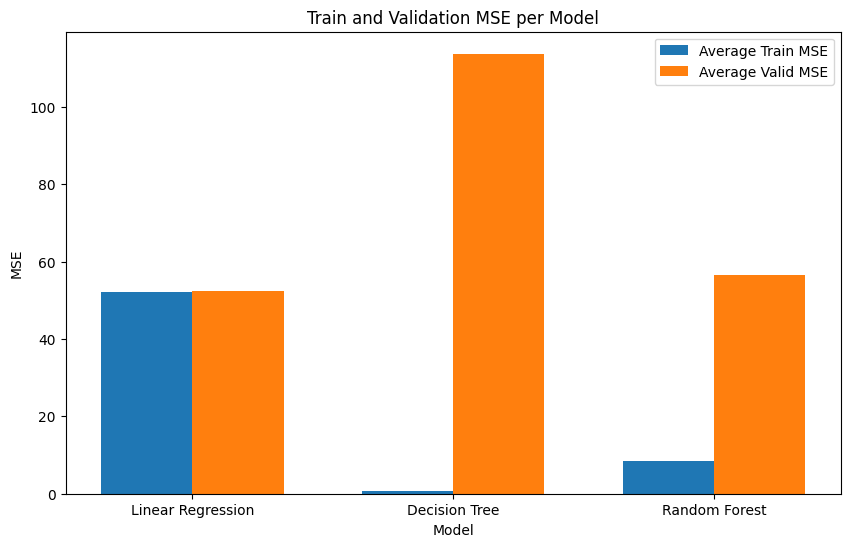

In [36]:
# Plotting the bar graph
bar_width = 0.35
index = np.arange(len(models))  # the label locations

plt.figure(figsize=(10, 6))

# Extracting train and validation MSEs for each model
train_mses = [model_performance[name]['train_mse'] for name in models]
valid_mses = [model_performance[name]['valid_mse'] for name in models]

bar1 = plt.bar(index, train_mses, bar_width, label='Average Train MSE')
bar2 = plt.bar(index + bar_width, valid_mses, bar_width, label='Average Valid MSE')

plt.xlabel('Model')
plt.ylabel('MSE')
plt.title('Train and Validation MSE per Model')
plt.xticks(index + bar_width / 2, models.keys())  # Use model names as x-ticks
plt.legend()


# Step 9: Tune the models

### Tuned linear regression model

In [45]:
# Redoing the polynomial degree analysis with degree up to 3
polynomial_mse = {'degree': [], 'train_mse': [], 'valid_mse': []}
for degree in range(1, 3):  
    model = make_pipeline(PolynomialFeatures(degree), LinearRegression())
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    train_mse = mean_squared_error(y_train, y_train_pred)
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    polynomial_mse['degree'].append(degree)
    polynomial_mse['train_mse'].append(train_mse)
    polynomial_mse['valid_mse'].append(valid_mse)

# Finding the degree with the lowest validation MSE
optimal_degree = polynomial_mse['degree'][np.argmin(polynomial_mse['valid_mse'])]
optimal_valid_mse = min(polynomial_mse['valid_mse'])

optimal_degree, optimal_valid_mse


(1, 52.3738605085526)

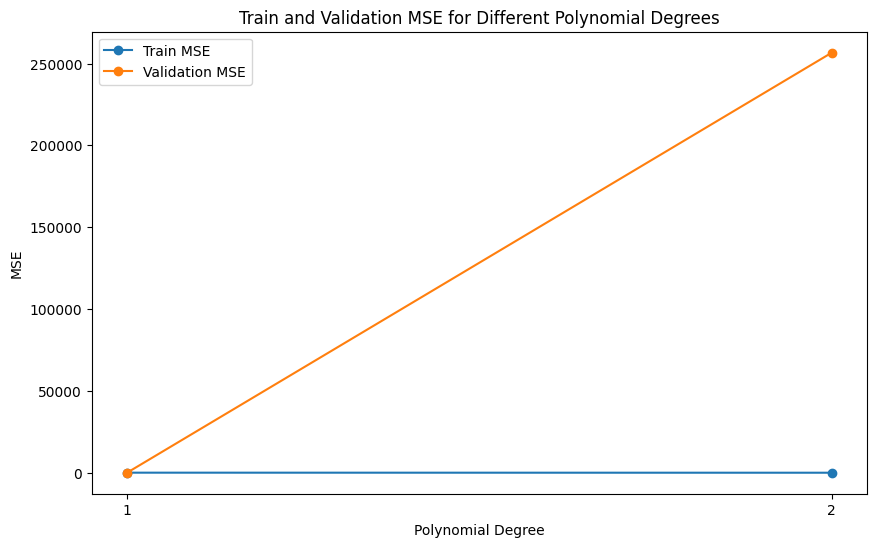

In [46]:
plt.figure(figsize=(10, 6))

# Plotting train MSE and validation MSE
plt.plot(polynomial_mse['degree'], polynomial_mse['train_mse'], label='Train MSE', marker='o')
plt.plot(polynomial_mse['degree'], polynomial_mse['valid_mse'], label='Validation MSE', marker='o')

plt.xlabel('Polynomial Degree')
plt.ylabel('MSE')
plt.title('Train and Validation MSE for Different Polynomial Degrees')
plt.xticks(polynomial_mse['degree'])  
plt.legend()

plt.show()

We therefore fit a linear regression model

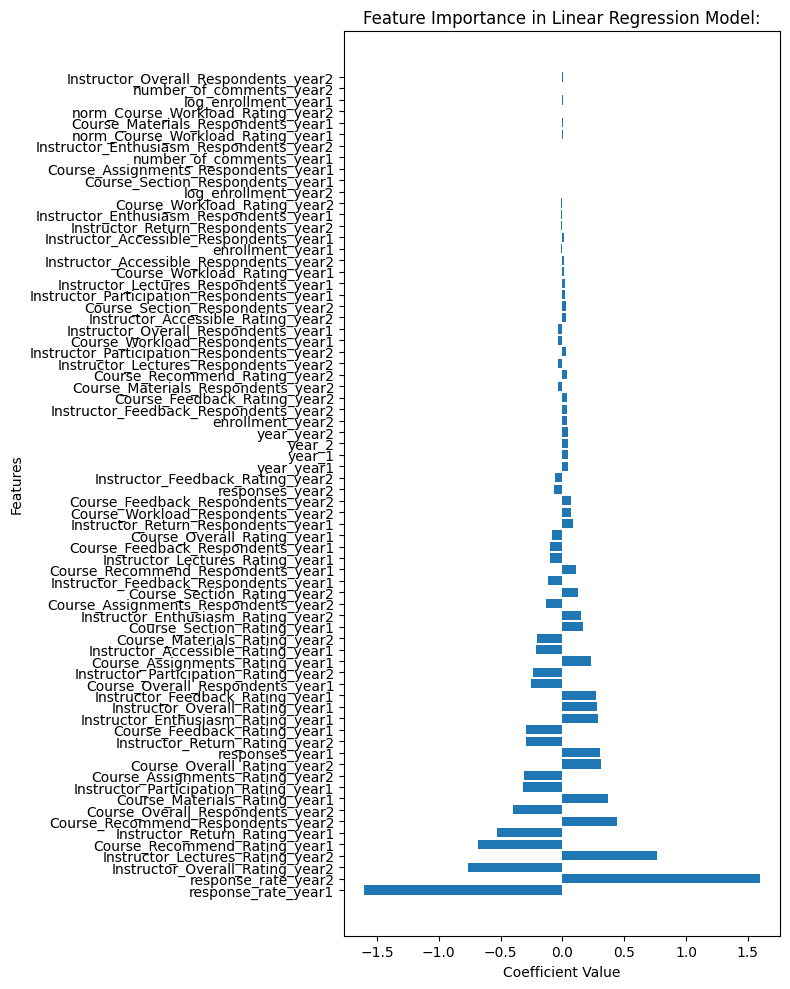

In [47]:
# Visualize coefficents:

# Fit the model according to the best degree = 1
model = LinearRegression().fit(X_train, y_train)

# Coefficients
coefficients = model.coef_

# Feature names
feature_names = X_train.columns

# Combine coefficients and feature names, and sort by the magnitude of coefficients
coeff_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
coeff_df = coeff_df.reindex(coeff_df.Coefficient.abs().sort_values(ascending=False).index)

# Plot
plt.figure(figsize=(8, 10))  # Adjust the figure size as needed
plt.barh(coeff_df['Feature'], coeff_df['Coefficient'])  # Horizontal bar plot
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.title(f'Feature Importance in Linear Regression Model:')
plt.tight_layout()  
plt.show()

## Trying to fix the linear regression using regularization

We had high hopes for our linear regression Model because of the coefficents on variables, however, to ensure interpretability and reduce potential overfitting we do regularization for the best model (degree 1)

c:\Users\AndrewsMatthewHaines\OneDrive - Harvard University\Documents\GitHub\cs109a_final_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 1.006e+05, tolerance: 2.091e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\AndrewsMatthewHaines\OneDrive - Harvard University\Documents\GitHub\cs109a_final_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 9.234e+04, tolerance: 2.091e+01
  model = cd_fast.enet_coordinate_descent(
c:\Users\AndrewsMatthewHaines\OneDrive - Harvard University\Documents\GitHub\cs109a_final_project\.venv\Lib\site-packages\sklearn\linear_m

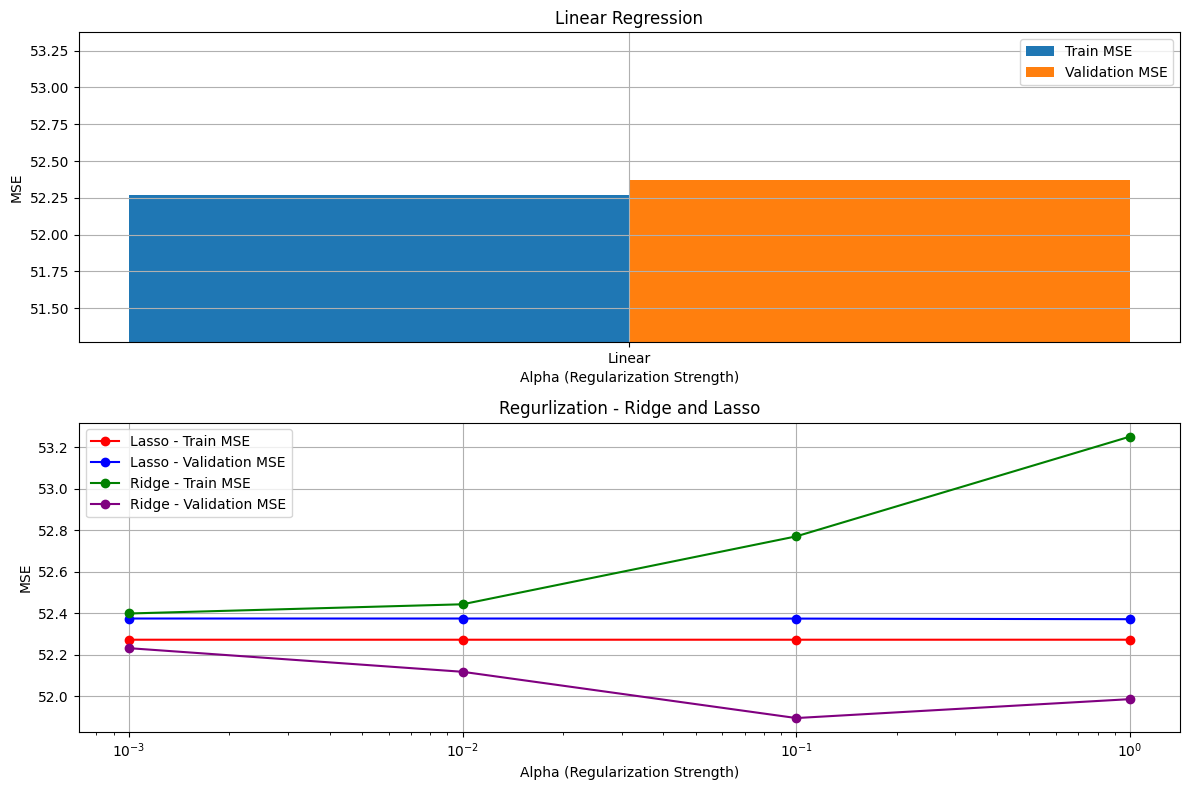

In [ ]:
# Initialize lists to store MSE values
alphas = [0.001, 0.01, 0.1, 1, 10]
train_mse = []
valid_mse = []
ridge_train_mse = []
ridge_valid_mse = []
lasso_train_mse = []
lasso_valid_mse = []

# Create and fit the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Calculate normal train and validation MSEs
y_train_pred = model.predict(X_train)
y_valid_pred = model.predict(X_valid)
train_mse.append(mean_squared_error(y_train, y_train_pred))
valid_mse.append(mean_squared_error(y_valid, y_valid_pred))

# Iterate over alpha values for Ridge and Lasso regression
for alpha in alphas:
    # Regularize using Ridge
    ridge_model = Ridge(alpha=alpha)
    ridge_model.fit(X_train, y_train)
    ridge_y_train_pred = ridge_model.predict(X_train)
    ridge_y_valid_pred = ridge_model.predict(X_valid)
    ridge_train_mse.append(mean_squared_error(y_train, ridge_y_train_pred))
    ridge_valid_mse.append(mean_squared_error(y_valid, ridge_y_valid_pred))

    # Regularize using Lasso
    lasso_model = Lasso(alpha=alpha)
    lasso_model.fit(X_train, y_train)
    lasso_y_train_pred = lasso_model.predict(X_train)
    lasso_y_valid_pred = lasso_model.predict(X_valid)
    lasso_train_mse.append(mean_squared_error(y_train, lasso_y_train_pred))
    lasso_valid_mse.append(mean_squared_error(y_valid, lasso_y_valid_pred))

# Creating subplots
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(12, 8))

# Linear Regression - Bar Plot
bar_width = 0.35
index = np.arange(len(train_mse))
axes[0].bar(index, train_mse, bar_width, label='Train MSE')
axes[0].bar(index + bar_width, valid_mse, bar_width, label='Validation MSE')
axes[0].set_title('Linear Regression')
axes[0].set_xticks(index + bar_width / 2)
axes[0].set_xticklabels(['Linear'])
axes[0].legend()
axes[0].grid(True)
y_max = max(max(train_mse), max(valid_mse)) + 1  # Add a small buffer
y_min = min(min(train_mse), min(valid_mse)) - 1  # Subtract a small buffer
axes[0].set_ylim(y_min, y_max)

# Ridge Regression
axes[1].plot(alphas, ridge_train_mse, label='Lasso - Train MSE', marker='o', color='red')
axes[1].plot(alphas, ridge_valid_mse, label='Lasso - Validation MSE', marker='o', color='blue')
axes[1].plot(alphas, lasso_train_mse, label='Ridge - Train MSE', marker='o', color='green')
axes[1].plot(alphas, lasso_valid_mse, label='Ridge - Validation MSE', marker='o', color='purple')
axes[1].set_title('Regurlization - Ridge and Lasso')
axes[1].set_xscale('log')
axes[1].legend()
axes[1].grid(True)

# General settings
for ax in axes:
    ax.set_xlabel('Alpha (Regularization Strength)')
    ax.set_ylabel('MSE')

# Display optimal alpha values
optimal_alpha_ridge = alphas[np.argmin(ridge_valid_mse)]
optimal_alpha_lasso = alphas[np.argmin(lasso_valid_mse)]

plt.tight_layout()
plt.show()

### Feature importance

c:\Users\AndrewsMatthewHaines\OneDrive - Harvard University\Documents\GitHub\cs109a_final_project\.venv\Lib\site-packages\sklearn\linear_model\_coordinate_descent.py:628: ConvergenceWarning: Objective did not converge. You might want to increase the number of iterations, check the scale of the features or consider increasing regularisation. Duality gap: 2.569e+04, tolerance: 2.091e+01
  model = cd_fast.enet_coordinate_descent(


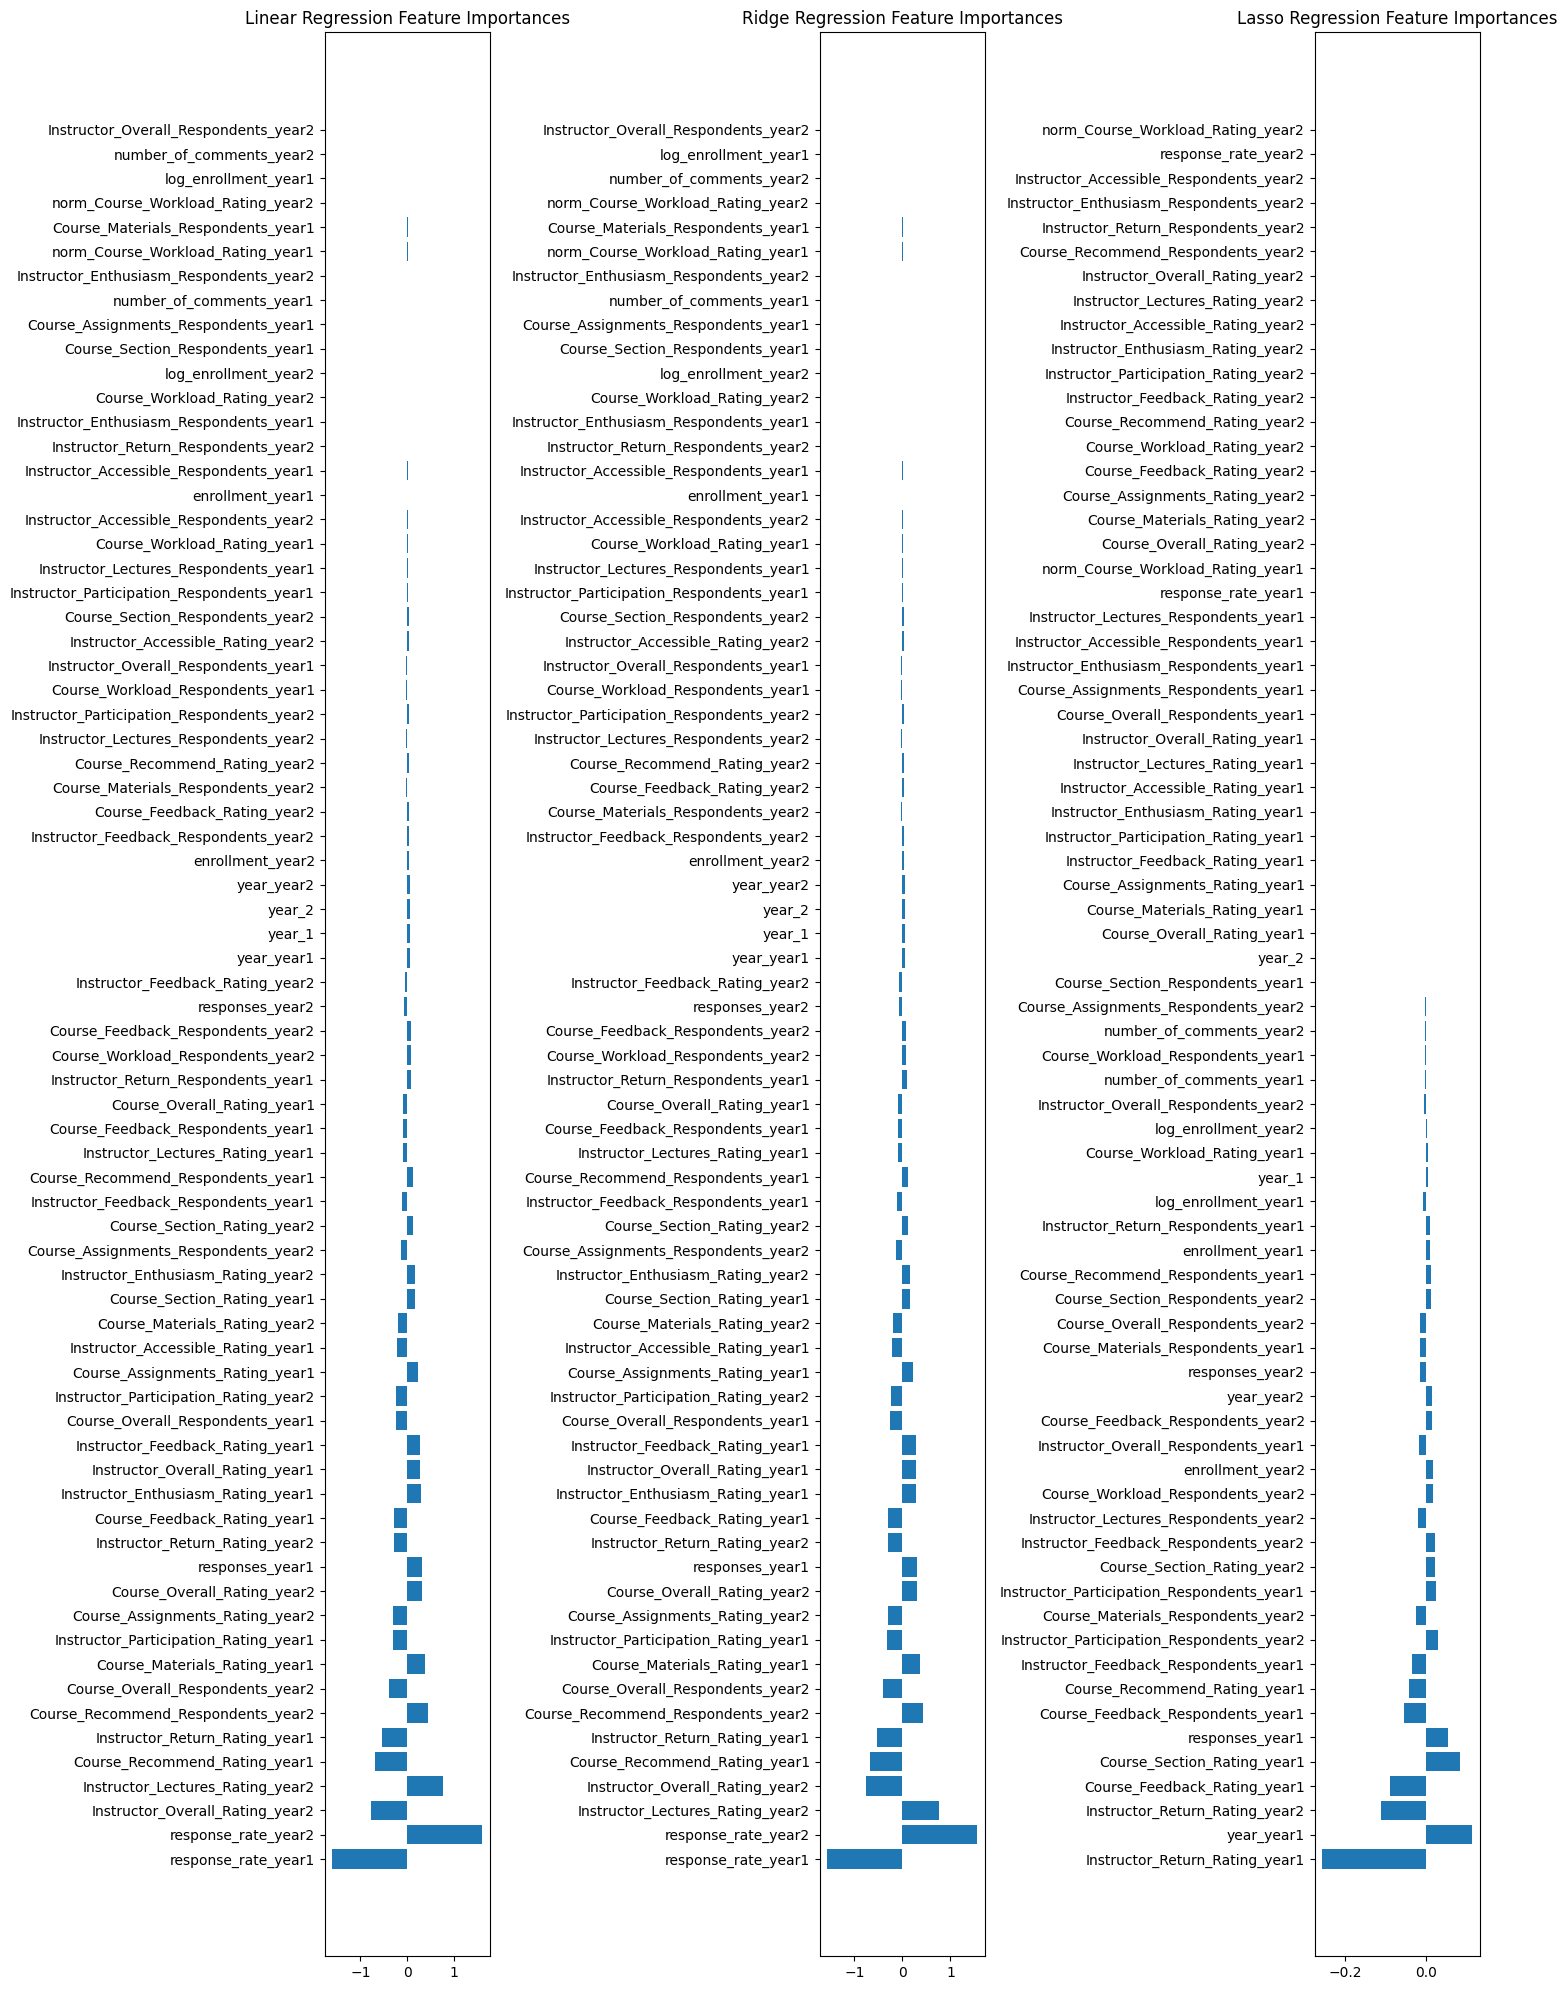

In [ ]:
# Train the linear regression model
model = LinearRegression()
model.fit(X_train, y_train)

# Get feature coefficients
linear_coeffs = model.coef_

# Ridge Regression
ridge_model = Ridge(alpha=optimal_alpha_ridge)
ridge_model.fit(X_train, y_train)
ridge_coeffs = ridge_model.coef_

# Lasso
lasso_model = Lasso(alpha=optimal_alpha_lasso)
lasso_model.fit(X_train, y_train)
lasso_coeffs = lasso_model.coef_

# Sort coefficients in descending order
linear_coeffs_sorted = sorted(enumerate(linear_coeffs), key=lambda x: abs(x[1]), reverse=True)
ridge_coeffs_sorted = sorted(enumerate(ridge_coeffs), key=lambda x: abs(x[1]), reverse=True)
lasso_coeffs_sorted = sorted(enumerate(lasso_coeffs), key=lambda x: abs(x[1]), reverse=True)

# Extract sorted feature indices and coefficients
linear_coeffs_indices, linear_coeffs_sorted = zip(*linear_coeffs_sorted)
ridge_coeffs_indices, ridge_coeffs_sorted = zip(*ridge_coeffs_sorted)
lasso_coeffs_indices, lasso_coeffs_sorted = zip(*lasso_coeffs_sorted)

# Plot feature importances
plt.figure(figsize=(15, 20))

# Linear Regression
plt.subplot(131)
plt.barh(range(len(linear_coeffs_sorted)), linear_coeffs_sorted)
plt.yticks(range(len(linear_coeffs_sorted)), [feature_names[i] for i in linear_coeffs_indices])
plt.title('Linear Regression Feature Importances')

# Ridge Regression
plt.subplot(132)
plt.barh(range(len(ridge_coeffs_sorted)), ridge_coeffs_sorted)
plt.yticks(range(len(ridge_coeffs_sorted)), [feature_names[i] for i in ridge_coeffs_indices])
plt.title('Ridge Regression Feature Importances')

# Lasso Regression
plt.subplot(133)
plt.barh(range(len(lasso_coeffs_sorted)), lasso_coeffs_sorted)
plt.yticks(range(len(lasso_coeffs_sorted)), [feature_names[i] for i in lasso_coeffs_indices])
plt.title('Lasso Regression Feature Importances')

plt.tight_layout()
plt.show()


### Tuned Decission tree model

In [48]:
# Redoing the decision tree analysis with different max_depth values
max_depth_mse = {'max_depth': [], 'train_mse': [], 'valid_mse': []}
for max_depth in range(1, 11):  # Trying max_depth values from 1 to 10
    model = DecisionTreeRegressor(max_depth=max_depth, random_state=42)
    model.fit(X_train, y_train)
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    train_mse = mean_squared_error(y_train, y_train_pred)
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    max_depth_mse['max_depth'].append(max_depth)
    max_depth_mse['train_mse'].append(train_mse)
    max_depth_mse['valid_mse'].append(valid_mse)

# Finding the max_depth with the lowest validation MSE
optimal_max_depth = max_depth_mse['max_depth'][np.argmin(max_depth_mse['valid_mse'])]
optimal_valid_mse = min(max_depth_mse['valid_mse'])

optimal_max_depth, optimal_valid_mse

(2, 51.66230320511478)

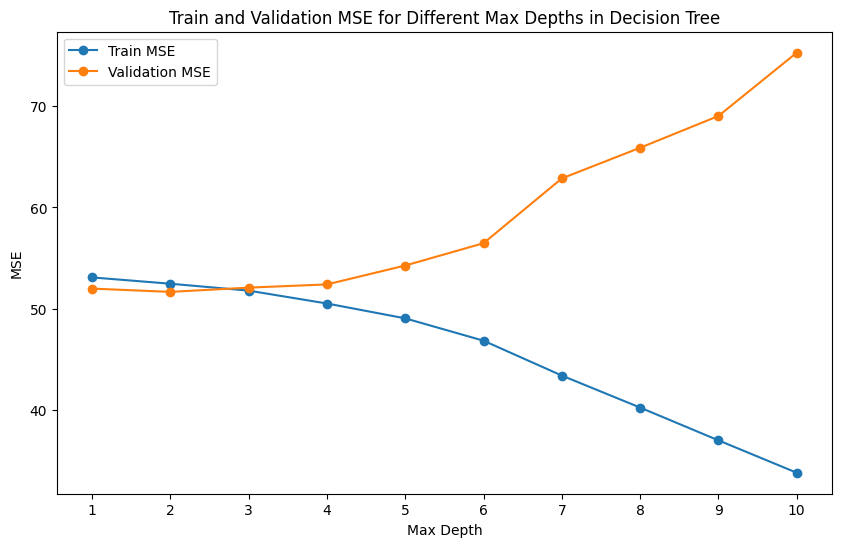

In [121]:
plt.figure(figsize=(10, 6))

# Plotting train MSE and validation MSE for different max_depth values
plt.plot(max_depth_mse['max_depth'], max_depth_mse['train_mse'], label='Train MSE', marker='o')
plt.plot(max_depth_mse['max_depth'], max_depth_mse['valid_mse'], label='Validation MSE', marker='o')

plt.xlabel('Max Depth')
plt.ylabel('MSE')
plt.title('Train and Validation MSE for Different Max Depths in Decision Tree')
plt.xticks(max_depth_mse['max_depth'])
plt.legend()

plt.show()

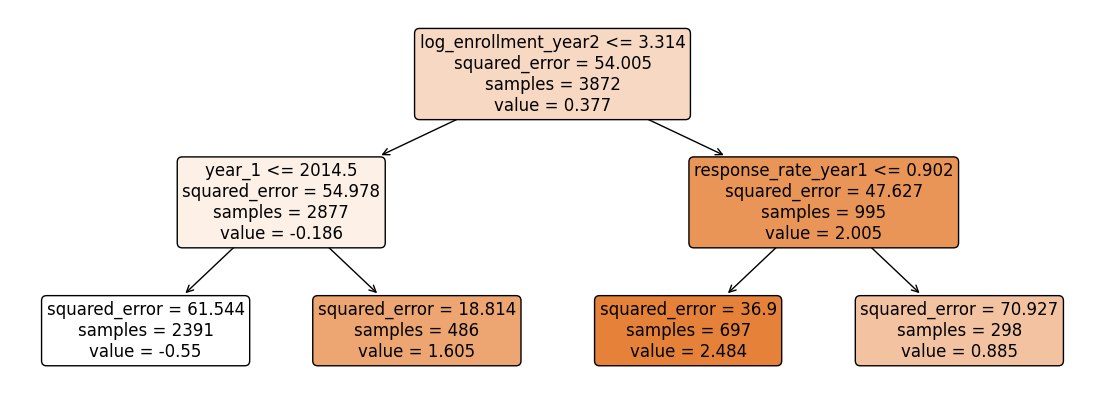

In [119]:
# Visualize the tree 
dt_best = DecisionTreeRegressor(max_depth=optimal_max_depth)
dt_best.fit(X_train, y_train)

feature_names=X_train.columns

# Visualize the tree
plt.figure(figsize=(14,5))
plot_tree(dt_best, filled=True, feature_names=feature_names, rounded=True, fontsize=12)
plt.show()

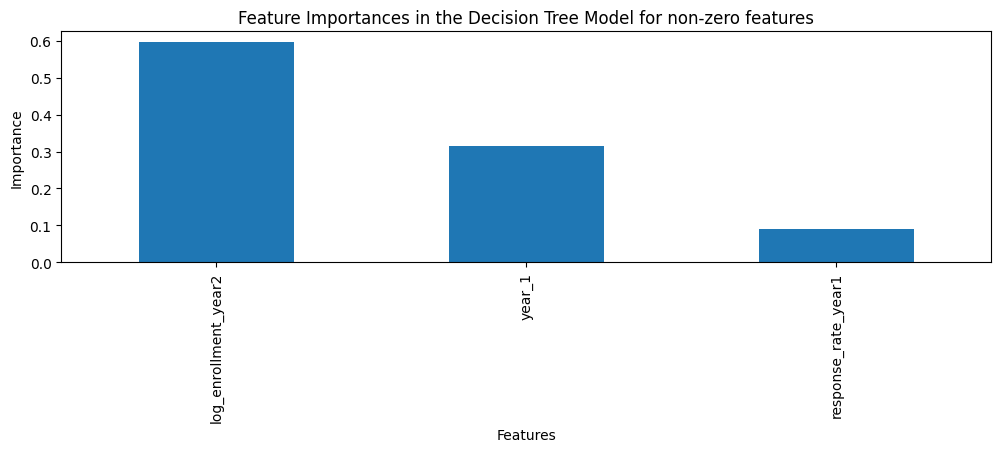

In [125]:
# Get feature importances and convert them into a Series
importances = pd.Series(dt_best.feature_importances_, index=feature_names)

# Filter out features with zero importance
filtered_importances = importances[importances > 0]

# Sort the feature importances in descending order
sorted_importances = filtered_importances.sort_values(ascending=False)

# Plot
plt.figure(figsize=(12, 3))
sorted_importances.plot(kind='bar')
plt.title("Feature Importances in the Decision Tree Model for non-zero features")
plt.ylabel("Importance")
plt.xlabel("Features")
plt.show()

### Tuned Random forest model

In [53]:
# Redoing the Random Forest analysis with different n_estimators and max_depth values
n_estimators_max_depth_mse = {'n_estimators': [], 'max_depth': [], 'train_mse': [], 'valid_mse': []}

n_estimators_range = [10, 50, 100, 150, 200]

for max_depth in range(1, 11): 
    for n_estimators in n_estimators_range:
        model = RandomForestRegressor(n_estimators=n_estimators, max_depth=max_depth, random_state=42)
        model.fit(X_train, y_train)
        y_train_pred = model.predict(X_train)
        y_valid_pred = model.predict(X_valid)
        train_mse = mean_squared_error(y_train, y_train_pred)
        valid_mse = mean_squared_error(y_valid, y_valid_pred)
        n_estimators_max_depth_mse['n_estimators'].append(n_estimators)
        n_estimators_max_depth_mse['max_depth'].append(max_depth)
        n_estimators_max_depth_mse['train_mse'].append(train_mse)
        n_estimators_max_depth_mse['valid_mse'].append(valid_mse)

# Finding the combination of n_estimators and max_depth with the lowest validation MSE
min_valid_mse_index = np.argmin(n_estimators_max_depth_mse['valid_mse'])
optimal_n_estimators = n_estimators_max_depth_mse['n_estimators'][min_valid_mse_index]
optimal_max_depth = n_estimators_max_depth_mse['max_depth'][min_valid_mse_index]
optimal_valid_mse = n_estimators_max_depth_mse['valid_mse'][min_valid_mse_index]

optimal_n_estimators, optimal_max_depth, optimal_valid_mse

(100, 2, 51.8127971690063)

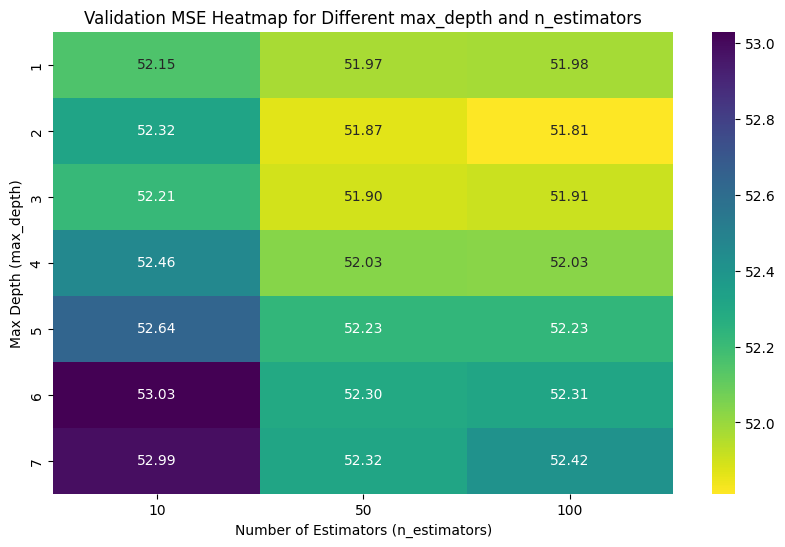

In [113]:
# Convert your results to a DataFrame for easier manipulation
df = pd.DataFrame(n_estimators_max_depth_mse)

# Pivot the DataFrame to get a matrix format suitable for heatmap
heatmap_data = df.pivot(index="max_depth", columns="n_estimators", values="valid_mse")

# Create the heatmap
plt.figure(figsize=(10, 6))
sns.heatmap(heatmap_data, annot=True, cmap='viridis_r', fmt = '.2f')
plt.title('Validation MSE Heatmap for Different max_depth and n_estimators')
plt.xlabel('Number of Estimators (n_estimators)')
plt.ylabel('Max Depth (max_depth)')
plt.show()

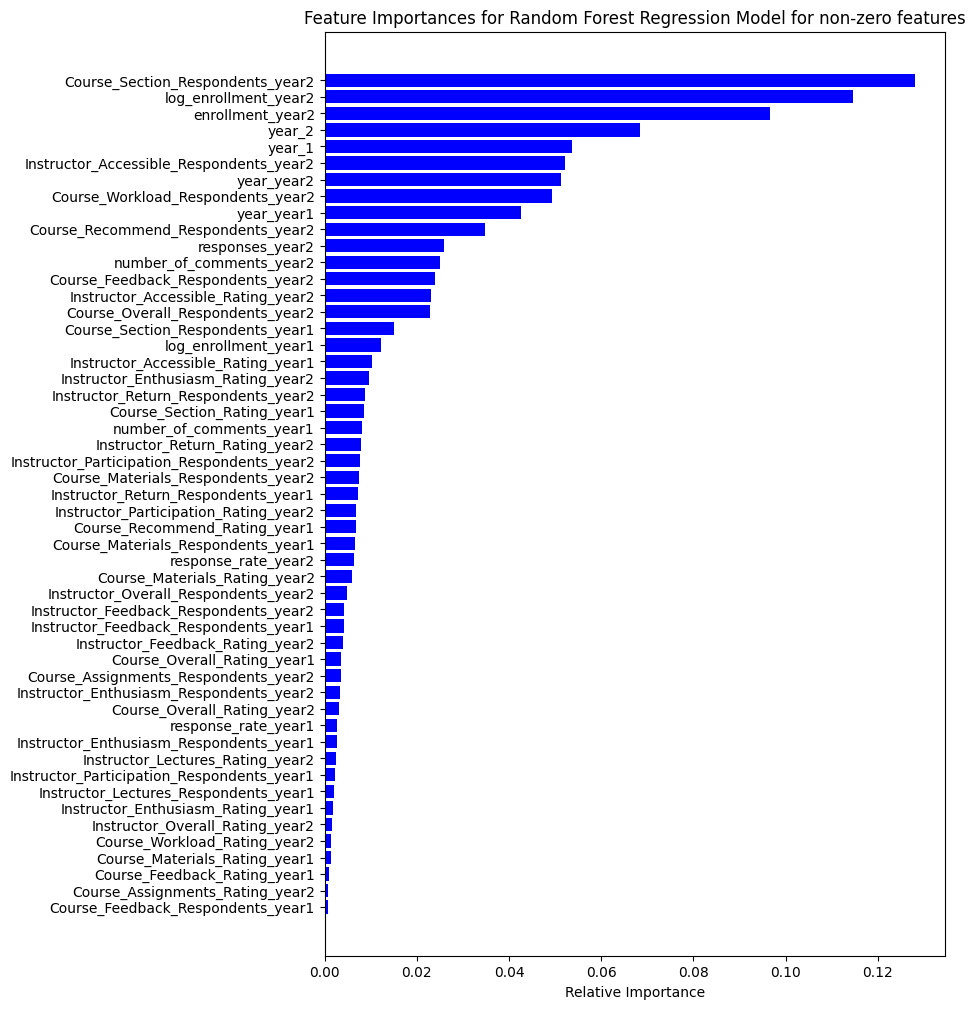

In [124]:
best_rf = RandomForestRegressor(n_estimators=optimal_n_estimators, max_depth=optimal_max_depth)

best_rf.fit(X_train, y_train)

feature_importances = best_rf.feature_importances_

# Create a mask for non-zero importances
non_zero_mask = feature_importances > 0

# Filter out features and their importances if their importance is non-zero
filtered_feature_importances = feature_importances[non_zero_mask]
filtered_features = np.array(feature_names)[non_zero_mask]

# Sort the features by their importance
indices = np.argsort(filtered_feature_importances)

plt.figure(figsize=(8, 12))
plt.title('Feature Importances for Random Forest Regression Model for non-zero features')
plt.barh(range(len(indices)), filtered_feature_importances[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(filtered_features)[indices])
plt.xlabel('Relative Importance')
plt.show()


# Step 10 PCA:

We wanted to try PCA since it would be useful to look at which components explain the most variance, and since PCA required transformations and wouldn't work as nicely with the baseline models we've done it seperately here:

Fine tune n_components

In [99]:
# Create a range of components to test
n_components_range = range(1, min(X_train.shape[0], X_train.shape[1]) + 1)

# Initialize lists to store explained variance and validation MSE
explained_variance = []
validation_mse = []

for n_components in n_components_range:
    # Create and fit the PCA model
    pca = PCA(n_components=n_components)
    X_train_pca = pca.fit_transform(X_train)
    X_valid_pca = pca.transform(X_valid)
    
    # Fit a regression model on the transformed data
    model = LinearRegression()
    model.fit(X_train_pca, y_train)
    
    # Make predictions and calculate MSE on the validation set
    y_valid_pred = model.predict(X_valid_pca)
    valid_mse = mean_squared_error(y_valid, y_valid_pred)
    
    # Store explained variance and validation MSE
    explained_variance.append(np.sum(pca.explained_variance_ratio_))
    validation_mse.append(valid_mse)

# Finding the number of components with the lowest validation MSE
total_variance = np.cumsum(pca.explained_variance_ratio_)
optimal_n_components = np.argmax(total_variance >= 0.98) + 1  # for 98% variance
optimal_valid_mse = validation_mse[optimal_n_components-1]

optimal_n_components, optimal_valid_mse

(6, 52.05261919077994)

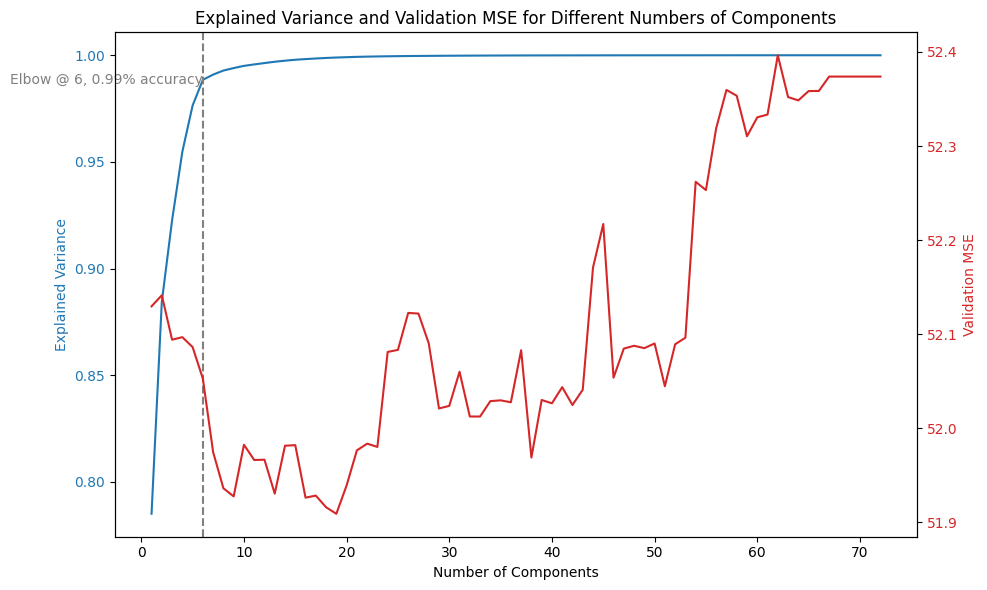

In [105]:
# Plotting
fig, ax1 = plt.subplots(figsize=(10, 6))

# Plot for explained variance
color = 'tab:blue'
ax1.set_xlabel('Number of Components')
ax1.set_ylabel('Explained Variance', color=color)
ax1.plot(n_components_range, explained_variance, label='Explained Variance', color=color)
ax1.tick_params(axis='y', labelcolor=color)

# Horizontal line for the elbow point in explained variance
elbow_y_value = explained_variance[optimal_n_components - 1]
ax1.axvline(x=optimal_n_components, color='gray', linestyle='--')
ax1.text(optimal_n_components, elbow_y_value, f'Elbow @ {optimal_n_components}, {np.round(elbow_y_value,2)}% accuracy', va='center', ha='right', color='gray')

# Second y-axis for validation MSE
ax2 = ax1.twinx()  
color = 'tab:red'
ax2.set_ylabel('Validation MSE', color=color)  
ax2.plot(n_components_range, validation_mse, label='Validation MSE', color=color)
ax2.tick_params(axis='y', labelcolor=color)

# Title and layout adjustment
plt.title('Explained Variance and Validation MSE for Different Numbers of Components')
fig.tight_layout()  
plt.show()

Run the best PCA model

In [59]:
# Create and fit the best PCA model
pca = PCA(n_components=optimal_n_components)
X_train_pca = pca.fit_transform(X_train)
X_valid_pca = pca.transform(X_valid)

# Fit a regression model on the transformed data
model = LinearRegression()
model.fit(X_train_pca, y_train)

LinearRegression()

# Step 11: Aggregate into results table

In [63]:
# accuracy_values = {
#     f"Best decision tree: max_depth = {dt_best_params}": {"train": dt_best_train_mse, "val": dt_best_valid_mse ,"test": dt_best_test_mse},
#     f"Best Random Forest: n_estimators = {best_params[0]} max_depth = {best_params[1]}": {"train": rf_best_train_mse, "val": rf_best_valid_mse,"test": rf_best_test_mse},
#     f"Best PCA, n_components = {best_n_components}": {"train": avg_train_mse_pca, "val": avg_valid_mse_pca, "test": avg_test_mse_pca},
#     f"Best Ridge, alpha = {round(best_alpha_ridge,2)}": {"train": avg_train_mse_ridge, "val": avg_valid_mse_ridge, "test": avg_test_mse_ridge},
#     f"Best Lasso, alpha = {round(best_alpha_lasso,2)}": {"train": avg_train_mse_lasso, "val": avg_valid_mse_lasso, "test": avg_test_mse_lasso}
# }

# # Creating the DataFrame
# results_df = pd.DataFrame(accuracy_values).transpose()
# results_df.columns = ['training accuracy', 'validation accuracy', 'test accuracy']

In [64]:
# # display results
# results_df

# Step 12: Interpretation of results

It's clear that the Best decision tree: max_depth = 27 is the best model followed by Best Random Forest: n_estimators = 100 max_depth = 5.


TODO: FIX

# Step 13: Final Model

In [65]:
# TODO 

## Look at where the model performs well (Arts, science etc.) - i.e. after testing look at MSE's grouped by X 

## Maybe connect to EDA

## TODO: 

- Results table
- Change names of models/ best params for the results table
- Do I standerdize the data before PCA/ Regurlization? For Seb


**Mike** - Add explanations after each step of why try this

**Matt**
- Check weighting over MSE thing? Goal isn't one model is it?

- Make sure you're predicting using average coefficents?

- Maybe average all models (1/MSE)
- More Feature importance 
- Look at where the model performs well (Arts, science etc.) - i.e. after testing look at MSE's grouped by X 

**Dan:**
- Maybe connect EDA to end 
- Check boxes for Milestones 